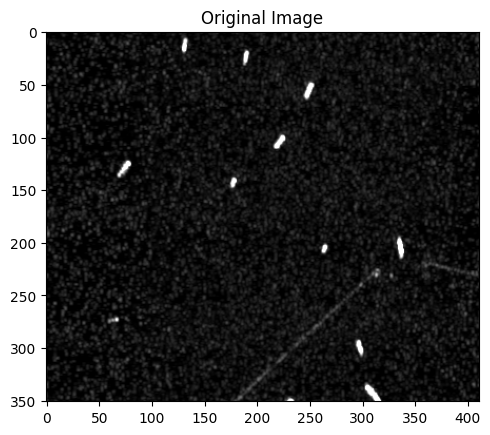

First ten values of the first row of backgroundNAN (Python): [41. 55. 55. 32.  6.  0.  0.  0.  0.  1.]


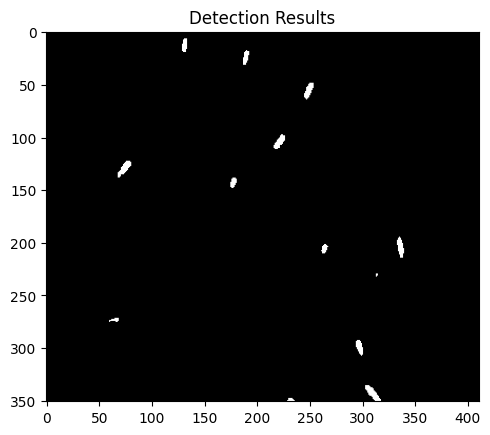

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from tkinter import Tk
from tkinter.filedialog import askopenfilename
from PIL import Image 

# Clean Up
plt.close('all')

# Initializations
back_size = 30  # background band size (RADIAL)
guard_size = 10  # guard band size (RADIAL)
PFA = 0.001  # desired Probability of False Alarm
detections = 0  # initialize detection count

# Read Image
Tk().withdraw()  # we don't want a full GUI, so keep the root window from appearing
filename = askopenfilename()  # show an "Open" dialog box and return the path to the selected file
# img = plt.imread(filename)
# img = img.astype(float)


img = Image.open(filename) 
img = np.array(img)  
if len(img.shape) == 3:
    img = img.mean(axis=2)
img = img.astype(float)


plt.figure()
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.show()

# Image Extension
h, w = img.shape
img_ext = np.pad(img, ((back_size, back_size), (back_size, back_size)), 'symmetric')

# Apply through image
for i in range(h):
    for j in range(w):
        ii = i + back_size
        jj = j + back_size
        cut = img[i, j]  # CUT is Cell Under Test (pixel of interest)

        # form bands
        guardband = img_ext[ii-guard_size:ii+guard_size+1, jj-guard_size:jj+guard_size+1]
        background = img_ext[ii-back_size:ii+back_size+1, jj-back_size:jj+back_size+1]
        backgroundNAN = background.copy()
        if i == 0 and j == 0:  # Just print for the first iteration
            print('First ten values of the first row of backgroundNAN (Python):', backgroundNAN[back_size, :10])

        backgroundNAN[(back_size-guard_size):(back_size+guard_size+1), (back_size-guard_size):(back_size+guard_size+1)] = np.NaN  # Remove CUT and GUARD
        

        re_back = backgroundNAN.flatten()  # Reshape into vector for calc
        re_back = re_back[~np.isnan(re_back)]

        # Cell Averaging CFAR
        mn = np.nanmean(re_back)
        N = (2*back_size+1)*(2*back_size+1) - (2*guard_size+1)*(2*guard_size+1)  # Number of background cells
        a = N*(PFA**(-1/N) - 1)
        TH = a*mn

        # Apply threshold
        if cut >= TH:
            if 'maskimg' not in locals():
                maskimg = np.zeros_like(img)
            maskimg[i, j] = 1
            detections += 1
        else:
            if 'maskimg' not in locals():
                maskimg = np.zeros_like(img)
            maskimg[i, j] = 0

plt.figure()
plt.imshow(maskimg, cmap='gray')
plt.title('Detection Results')
plt.show()
